# GAN To Generate Digits

Using mnist dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Reshape
from tensorflow.keras.regularizers import L1L2

In [3]:
(x_train, _), (_, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size= 60000).batch(batch_size= 256)

In [5]:
# generator
generator = Sequential()
generator.add(Dense(units= 500, input_dim= 100, activation= 'relu', kernel_regularizer= L1L2(1e-5, 1e-5)))
generator.add(Dense(units= 500, activation= 'relu', kernel_regularizer= L1L2(1e-5, 1e-5)))
generator.add(Dense(units= 784, activation= 'relu', kernel_regularizer= L1L2(1e-5, 1e-5))) # i could use sigmoid to output values between 0 and 1
generator.add(Reshape((28, 28)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# discriminator
discriminator = Sequential()
discriminator.add(InputLayer(shape= (28, 28)))
discriminator.add(Flatten())
discriminator.add(Dense(units= 500, activation= 'relu', kernel_regularizer= L1L2(1e-5, 1e-5)))
discriminator.add(Dense(units= 500, activation= 'relu', kernel_regularizer= L1L2(1e-5, 1e-5)))
discriminator.add(Dense(units= 1, activation= 'sigmoid', kernel_regularizer= L1L2(1e-5, 1e-5)))

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [8]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss


In [9]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

epochs = 100
noise_dim = 100

In [10]:
def train_step(images):
    noise = tf.random.normal([256, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training= True)

        real_output = discriminator(images, training= True)
        fake_output = discriminator(generated_images, training= True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [11]:
for epoch in range(epochs):
    for image_batch in x_train:
        gen_loss_batch, disc_loss_batch = train_step(image_batch)

    print(f'Epoch {epoch} | gen_loss: {gen_loss_batch}  disc_loss: {disc_loss_batch}')

Epoch 0 | gen_loss: 3.655819892883301  disc_loss: 0.13469548523426056
Epoch 1 | gen_loss: 6.076817035675049  disc_loss: 0.019812142476439476
Epoch 2 | gen_loss: 6.306717395782471  disc_loss: 0.01787249743938446
Epoch 3 | gen_loss: 6.496811866760254  disc_loss: 0.007396480534225702
Epoch 4 | gen_loss: 4.583252429962158  disc_loss: 0.02062758430838585
Epoch 5 | gen_loss: 3.594409704208374  disc_loss: 0.06901717185974121
Epoch 6 | gen_loss: 5.544412612915039  disc_loss: 0.012729797512292862
Epoch 7 | gen_loss: 6.30837345123291  disc_loss: 0.006759085692465305
Epoch 8 | gen_loss: 8.203827857971191  disc_loss: 0.007096576504409313
Epoch 9 | gen_loss: 8.110878944396973  disc_loss: 0.003334753680974245
Epoch 10 | gen_loss: 7.5764665603637695  disc_loss: 0.003114988561719656
Epoch 11 | gen_loss: 7.897554874420166  disc_loss: 0.001582156983204186
Epoch 12 | gen_loss: 8.548362731933594  disc_loss: 0.0018523454200476408
Epoch 13 | gen_loss: 8.268168449401855  disc_loss: 0.0034745284356176853
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


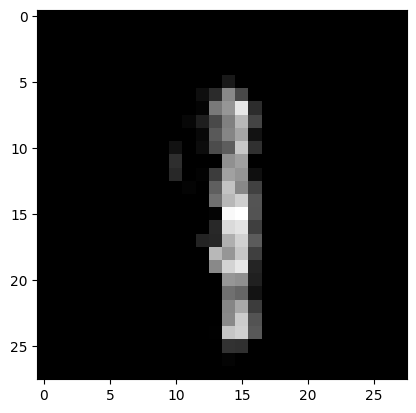

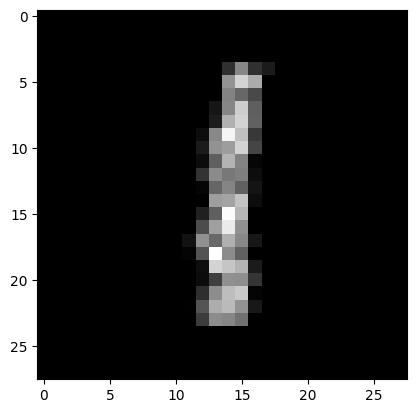

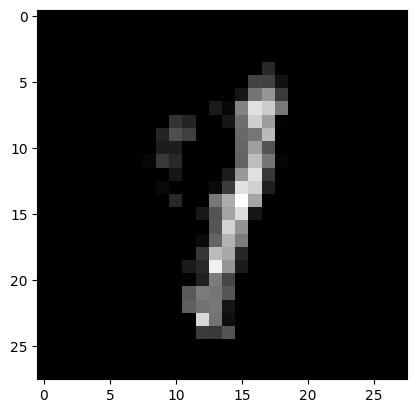

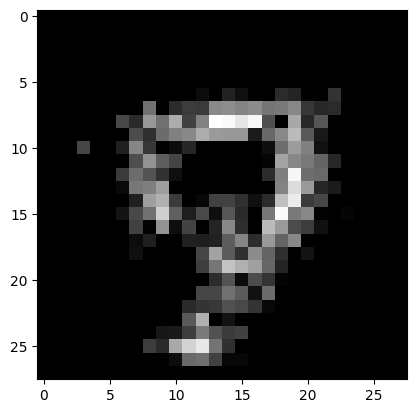

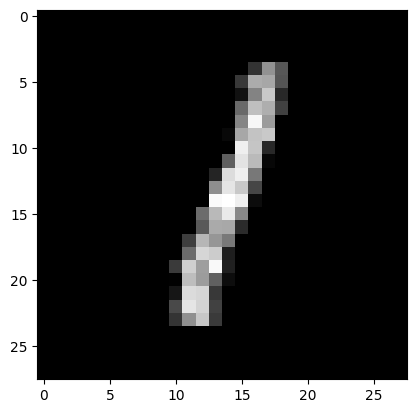

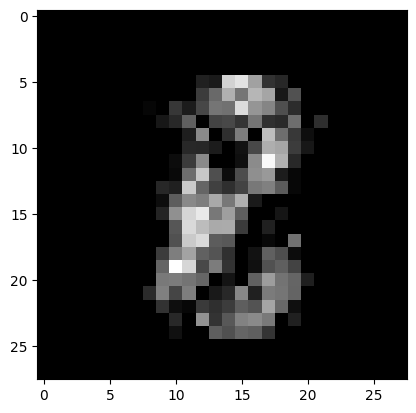

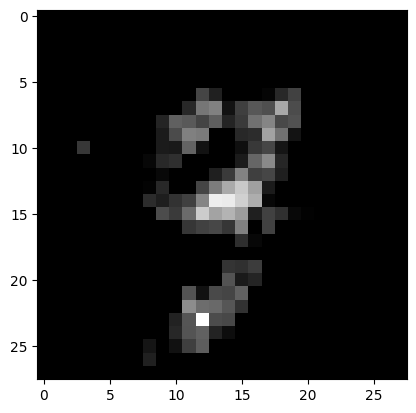

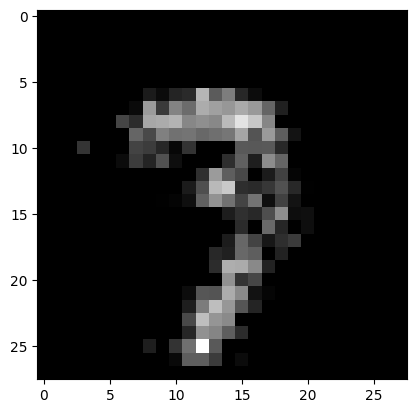

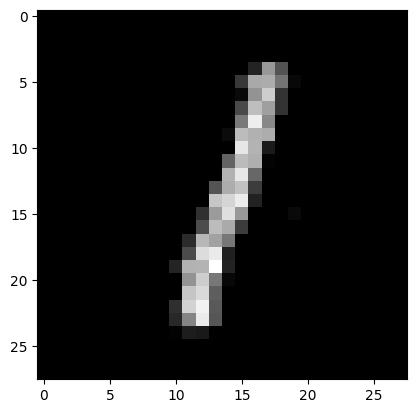

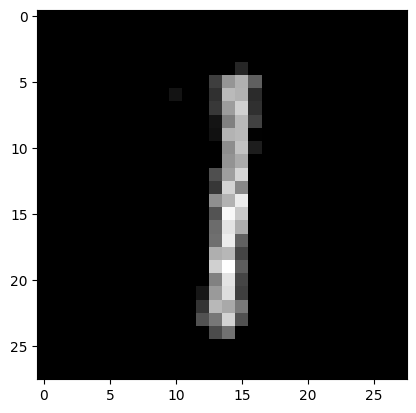

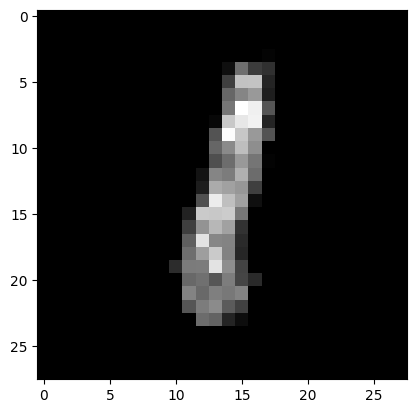

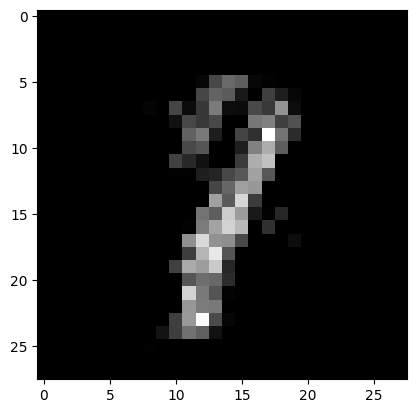

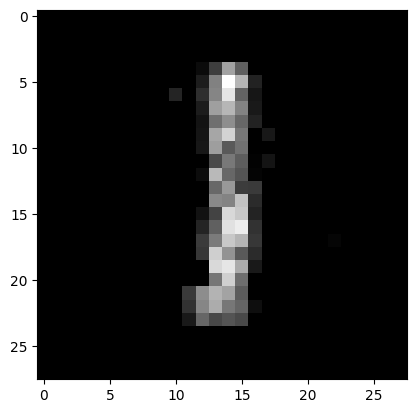

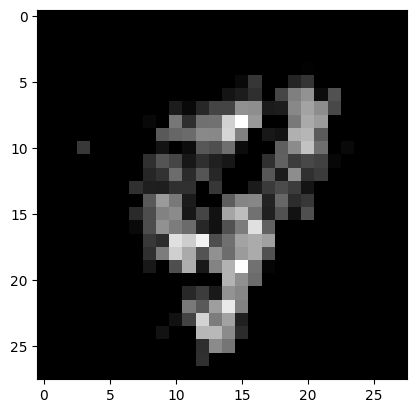

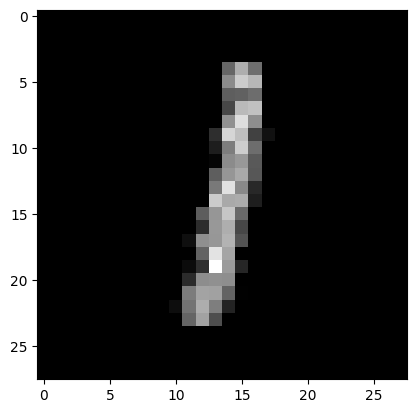

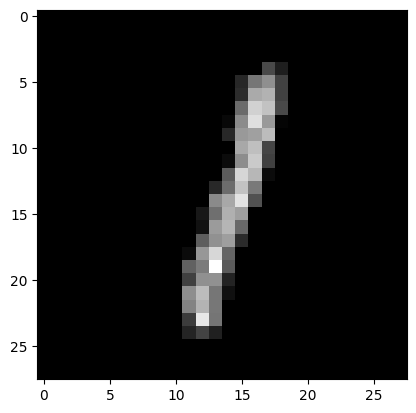

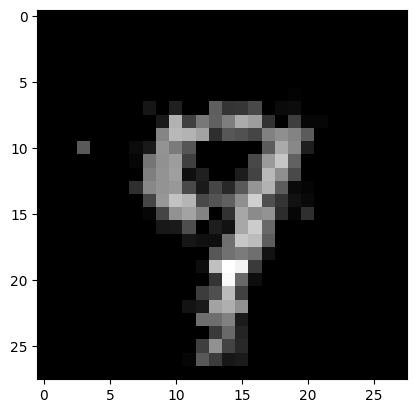

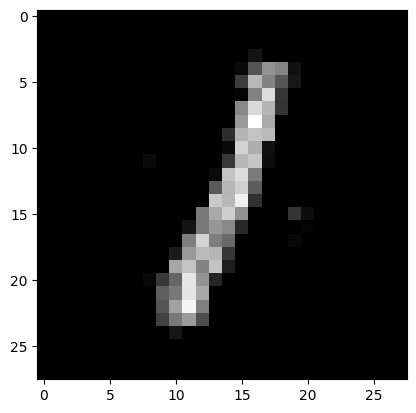

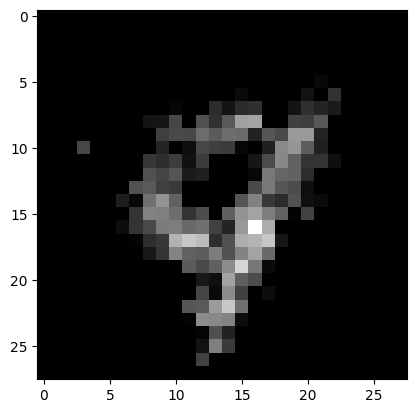

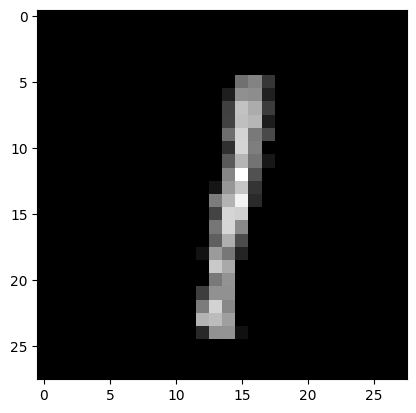

In [12]:
samples = np.random.normal(size= (20, 100))
prediction = generator.predict(samples)

for i in range(prediction.shape[0]):
    plt.imshow(prediction[i, :], cmap= 'gray')
    plt.show()